# Preamble

In [1]:
# imports copied from Ryan's Note19 code for now to avoid weird unicode issue
import meep as mp
import meep.materials as mats
from meep import mpb
import meeputils as mu
from wurlitzer import pipes, STDOUT
from io import StringIO
from scipy.interpolate import RectBivariateSpline

# my additions
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Definitions

In [2]:
# function definitions copied from Ryan's Note19 code for now to avoid weird unicode issue

# get_wgparams:  Solves at some wavelength lam with size W, H, h, etc.
def get_wgparams(W, H, h, lam, do_func=None, solver=None):
    # if not (solver is None):
    #     ms = solver
    # Set up geometry.
    nSi = mu.get_index('Si', lam); ngSi = mu.get_ng('Si', lam)
    nSiO2 = mu.get_index('SiO2', lam); ngSiO2 = mu.get_ng('SiO2', lam)
    Si = mp.Medium(index=nSi); SiO2 = mp.Medium(index=nSiO2)

    ms = mpb.ModeSolver(geometry_lattice=lat,
                        geometry=[],
                        k_points=k_points,
                        resolution=res,
                        num_bands=n_bands,
                        default_material=SiO2)

    geom = [#mp.Block(size=mp.Vector3(mp.inf, mp.inf, -Wgrid/2), center=mp.Vector3(0, 0, -Wgrid/4), material=SiO2),
            mp.Block(size=mp.Vector3(mp.inf, W, H), material=Si),
            mp.Block(size=mp.Vector3(mp.inf, mp.inf, h), center=mp.Vector3(0, 0, -(H-h)/2), material=Si)]
    ms.geometry = geom
    ms.default_material = SiO2

    blackhole = StringIO()
    with pipes(stdout=blackhole, stderr=STDOUT):
        ms.init_params(mp.NO_PARITY, False)
        eps = np.array(ms.get_epsilon())
    isSi = (eps - nSiO2 ** 2) / (nSi ** 2 - nSiO2 ** 2)

    out = {}

    def get_fieldprops(ms, band):
        if (out != {}):
            return
        e = np.array(ms.get_efield(band))
        eps_ei2 = eps.reshape(eps.shape+(1,)) * np.abs(e[:, :, 0, :]**2)
        ei_pwr = eps_ei2.sum(axis=(0, 1))
        if (ei_pwr[1] > ei_pwr[2]):
            print ("TE mode!\n")
            # Calculate eps |E|^2.  Then get power in the silicon, and distribution along x.
            # Get n_g.  Adjust by material disperision factor (n_{g,mat}/n_{mat}), weighted by eps |E|^2 above.
            epwr = eps_ei2.sum(-1) / eps_ei2.sum()
            pSi_x = (epwr * isSi).sum(-1)
            pSi = pSi_x.sum()
            pSi_strip = (pSi_x * (np.abs(np.linspace(-Wgrid/2, Wgrid/2, len(pSi_x))) <= W/2)).sum()
            ng_nodisp = 1 / ms.compute_one_group_velocity_component(mp.Vector3(1, 0, 0), band)
            ng = ng_nodisp * (pSi * (ngSi / nSi) + (1 - pSi) * (ngSiO2 / nSiO2))

            # Output various stuff.
            out['band'] = band
            out['ng'] = ng
            out['pSi'] = pSi
            out['pSi_x'] = pSi_x #np.array(pSi_x[len(pSi_x)//2:] * 2)
            out['pSi_strip'] = pSi_strip

            if (do_func != None):
                do_func(out, ms, band)

    with pipes(stdout=blackhole, stderr=STDOUT):
        k = ms.find_k(mp.NO_PARITY,
                      1/lam,
                      1, 1,
                      mp.Vector3(1, 0, 0),
                      1e-4,
                      (nSiO2+nSi)/(2*lam), nSiO2/lam, nSi/lam,
                      get_fieldprops)

    if (out == {}):
        print ("TE mode not found.")
        return out

    out['neff'] = k[out['band']-1] / (1 / lam)

    print ("lam = {:.2f}, W = {:.2f}, H = {:.2f}, h = {:.2f}, neff = {:.3f}, ng = {:.3f}, "
           "pSi = {:.2f}, pStrip = {:.2f}".format(lam, W, H, h, out['neff'], out['ng'], out['pSi'], out['pSi_strip']))
    return out

# interp_grid:   Interpolates a coarse grid to a fine one (useful for nice contour plotting)
def interp_grid(z, fact=2):
    (nx, ny) = z.shape
    (x1, y1) = (np.linspace(0, 1, nx), np.linspace(0, 1, ny))
    (x2, y2) = (np.linspace(0, 1, (nx - 1) * fact + 1), np.linspace(0, 1, (ny - 1) * fact + 1))
    sp = RectBivariateSpline(x1, y1, z, kx=1, ky=1)
    return sp(x2, y2)



In [3]:
# waveguide dispersion sweep parameters

Wlist = np.linspace(0.4, 1.0, 25) 
Hlist = np.linspace(0.2, 0.7, 21) 
hlist = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
lamList = np.array([1.2, 1.3, 1.4, 1.55, 1.8, 2.0])

(Wgrid, Hgrid) = (2, 2)


n_points = 32
n_bands  = 4
res      = 128
## old code solving along x
# k_points = mp.interpolate(n_points, [mp.Vector3(0.05, 0, 0), mp.Vector3(0.05*n_points, 0, 0)])
# lat = mp.Lattice(size=mp.Vector3(0, Wgrid, Hgrid))

# new code solving along z
k_points = mp.interpolate(n_points, [mp.Vector3(0, 0, 0.05), mp.Vector3(0, 0, 0.05*n_points)])
lat = mp.Lattice(size=mp.Vector3(Wgrid, Hgrid, 0))

In [4]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

def conformal_verts(obj,t):
    """
    Returns a list of vertices for a "conformal" meep Prism object around the meep/mpb geometry
    object obj with thickness t
    
    inputs:
    obj:  meep/mpb geometry object
    t:    conformal layer thickness in um (float)
    
    outputs:
    conformal_vertices:  list of meep.Vector3 vector objects 
    """
    verts = obj.vertices
    edges = [verts[ind+1]-verts[ind] for ind in range(len(verts)-1)] + [verts[0]-verts[-1],]
    edge_centers = [verts[ind]+edges[ind]/2. for ind in range(len(verts))] 
    edge_normals = [ mp.Vector3(0,0,1).cross(e).unit() for e in edges ]
    ts = [t for v in verts] # * np.ones(len(verts))
    for ind in range(len(verts)):
        if mp.is_point_in_object(edge_centers[ind] + edge_normals[ind]*0.001, obj):
            print(f'reversing edge normal {ind}')
            edge_normals[ind] = edge_normals[ind] * -1
        if edge_normals[ind][1] < 0:
            ts[ind] = 0.
    vrts = [(verts[ind]+ts[ind]*edge_normals[ind],verts[ind+1]+ts[ind]*edge_normals[ind]) for ind in range(len(verts)-1)] + [( verts[-1]+ts[-1]*edge_normals[-1], verts[0]+ts[-1]*edge_normals[-1] ),]
    conformal_verts_init = [ get_intersect((vrts[ind][0][0],vrts[ind][0][1]),
                                      (vrts[ind][1][0],vrts[ind][1][1]),
                                      (vrts[ind+1][0][0],vrts[ind+1][0][1]),
                                      (vrts[ind+1][1][0],vrts[ind+1][1][1])) for ind in range(len(verts)-1)]
    conformal_verts_init += [ get_intersect((vrts[-1][0][0],vrts[-1][0][1]),
                                      (vrts[-1][1][0],vrts[-1][1][1]),
                                      (vrts[0][0][0],vrts[0][0][1]),
                                      (vrts[0][1][0],vrts[0][1][1])), ]
    conformal_verts_final = [mp.Vector3(v[0],v[1],0.) for v in conformal_verts_init]
    return conformal_verts_final

# Single geometry instance

In [5]:
# single waveguide instance parameters

# define new parameters for angled sidewalls, partial etch, conformal deposited layers after wg etch,

θ = 20. #10. # sidewall angle in degrees, 0 = vertical
w_top = 0.5 # top width of partially etched "core layer" in microns
t_core = 0.2 # full thickness of "core layer" in microns
t_etch = 0.15 # etch depth into "core layer" in microns
t_ald = .05
lam = 0.5 # free space wavelength in microns
dx_base = np.tan(np.deg2rad(θ)) * t_etch
# W = 0.5
# H = 0.2
# h = 0.05




In [26]:
# definite material variables
nAlOx = mu.get_index('Alumina', lam)
ngAlOx = mu.get_ng('Alumina', lam)
nHfO2 = mu.get_index('Hafnia', lam)
ngHfO2 = mu.get_ng('Hafnia', lam)
nSiO2 = mu.get_index('SiO2', lam)
ngSiO2 = mu.get_ng('SiO2', lam)

AlOx = mp.Medium(index=nAlOx)
HfO2 = mp.Medium(index=nHfO2)
SiO2 = mp.Medium(index=nSiO2)
Air = mp.Medium(index=1)

In [16]:
verts_core = [mp.Vector3(-w_top/2.,t_core),
            mp.Vector3(w_top/2.,t_core),
            mp.Vector3(w_top/2+dx_base,t_core-t_etch),
            mp.Vector3(-w_top/2-dx_base,t_core-t_etch),
           ]

core = mp.Prism(verts_core, height=mp.inf, material=AlOx)
slab = mp.Block(size=mp.Vector3(mp.inf, t_core-t_etch , mp.inf), center=mp.Vector3(0, (t_core-t_etch), 0),material=AlOx)
ald_core = mp.Prism(conformal_verts(core,t_ald), height=mp.inf, material=HfO2)
ald_slab = mp.Block(size=mp.Vector3(mp.inf, t_ald , mp.inf), center=mp.Vector3(0, (t_core-t_etch+t_ald), 0), material=HfO2)

geom = [ald_core,
        ald_slab,
        core,
        slab,
       ]



#verts_ald = [v + mp.Vector3(0,t_ald,0) for v in verts_core]


In [34]:
slab.material.epsilon(0)[0,0] == AlOx.epsilon(0)[0,0]

True

In [8]:
# define hard-coded waveguide mode-solver script for this geometry and run it

do_func = None



ms = mpb.ModeSolver(geometry_lattice=lat,
                    geometry=[],
                    k_points=k_points,
                    resolution=res,
                    num_bands=n_bands,
                    default_material=SiO2)

ms.geometry = geom
ms.default_material = SiO2

blackhole = StringIO()
with pipes(stdout=blackhole, stderr=STDOUT):
    ms.init_params(mp.NO_PARITY, False)
    eps = np.array(ms.get_epsilon())
isAlOx = (eps - nSiO2 ** 2) / (nAlOx ** 2 - nSiO2 ** 2)

out = {}

def get_fieldprops(ms, band):
    if (out != {}):
        return
    e = np.array(ms.get_efield(band))
    eps_ei2 = eps.reshape(eps.shape+(1,)) * np.abs(e[:, :, 0, :]**2)
    ei_pwr = eps_ei2.sum(axis=(0, 1))
    if (ei_pwr[1] > ei_pwr[2]):
        print ("TE mode!\n")
        # Calculate eps |E|^2.  Then get power in the silicon, and distribution along x.
        # Get n_g.  Adjust by material disperision factor (n_{g,mat}/n_{mat}), weighted by eps |E|^2 above.
        epwr = eps_ei2.sum(-1) / eps_ei2.sum()
        pAlOx_x = (epwr * isAlOx).sum(-1)
        pAlOx = pAlOx_x.sum()
        pAlOx_strip = np.zeros(len(pAlOx_x)) # (pAlOx_x * (np.abs(np.linspace(-Wgrid/2, Wgrid/2, len(pAlOx_x))) <= W/2)).sum()
        ng_nodisp = 1 / ms.compute_one_group_velocity_component(mp.Vector3(1, 0, 0), band)
        ng = ng_nodisp * (pAlOx * (ngAlOx / nAlOx) + (1 - pAlOx) * (ngSiO2 / nSiO2))

        # Output various stuff.
        out['band'] = band
        out['ng'] = ng
        out['pAlOx'] = pAlOx
        out['pAlOx_x'] = pAlOx_x #np.array(pSi_x[len(pSi_x)//2:] * 2)
        out['pAlOx_strip'] = pAlOx_strip

        if (do_func != None):
            do_func(out, ms, band)

# ModeSolver.find_k(p, omega, band_min, band_max, korig_and_kdir, tol, kmag_guess, kmag_min, kmag_max, *band_func)
            
with pipes(stdout=blackhole, stderr=STDOUT):
    k = ms.find_k(mp.NO_PARITY,
                  1/lam,
                  1,
                  1,
                  mp.Vector3(0, 0, 1),
                  1e-4,
                  (nSiO2+nAlOx)/(2*lam),
                  nSiO2/lam,
                  nAlOx/lam,
                  get_fieldprops)

# if (out == {}):
#     print ("TE mode not found.")
#     return out

# out['neff'] = k[out['band']-1] / (1 / lam)

# print ("lam = {:.2f}, W = {:.2f}, H = {:.2f}, h = {:.2f}, neff = {:.3f}, ng = {:.3f}, "
#        "pAlOx = {:.2f}, pStrip = {:.2f}".format(lam, W, H, h, out['neff'], out['ng'], out['pAlOx'], out['pAlOx_strip']))

band = 1
e = np.array(ms.get_efield(band))
eps_ei2 = eps.reshape(eps.shape+(1,)) * np.abs(e[:, :, 0, :]**2)
ei_pwr = eps_ei2.sum(axis=(0, 1))

if (ei_pwr[0] > ei_pwr[1]):
    print ("TE mode!\n")
    # Calculate eps |E|^2.  Then get power in each material, and distribution along x.
    # Get n_g.  Adjust by material disperision factor (n_{g,mat}/n_{mat}), weighted by eps |E|^2 above.
    epwr = eps_ei2.sum(-1) / eps_ei2.sum()
    
    pAlOx_x = (epwr * isAlOx).sum(-1)
    pAlOx = pAlOx_x.sum()
    pAlOx_strip = (pAlOx_x * (np.abs(np.linspace(-Wgrid/2, Wgrid/2, len(pAlOx_x))) <= w_top/2)).sum()
    ng_nodisp = 1 / ms.compute_one_group_velocity_component(mp.Vector3(0, 0, 1), band)
    ng = ng_nodisp * (pAlOx * (ngAlOx / nAlOx) + (1 - pAlOx) * (ngSiO2 / nSiO2))

    # Output various stuff.
    out['band'] = band
    out['ng'] = ng
    out['pAlOx'] = pAlOx
    out['pAlOx_x'] = pAlOx_x #np.array(pSi_x[len(pSi_x)//2:] * 2)
    out['pAlOx_strip'] = pAlOx_strip

Working in 2 dimensions.
Grid size is 256 x 256 x 1.
Solving for 4 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (2, 0, 0)
     (0, 2, 0)
     (0, 0, 1)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (0.5, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 1)
Geometric objects:
     prism, center = (0,0.15,5e+19)
          height 1e+20, axis (0,0,1), 4 vertices:
          (0.28501,0.25,0)
          (0.357804,0.05,0)
          (-0.357804,0.05,0)
          (-0.28501,0.25,0)
     block, center = (0,0.1,0)
          size (1e+20,0.05,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     prism, center = (0,0.125,5e+19)
          height 1e+20, axis (0,0,1), 4 vertices:
          (-0.25,0.2,0)
          (0.25,0.2,0)
          (0.304596,0.05,0)
          (-0.304596,0.05,0)
     block, center = (0,0.05,0)
          size (1e+20,0.05,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 8 object nodes (vs. 4 actual objects)
Initializi

(256, 256)

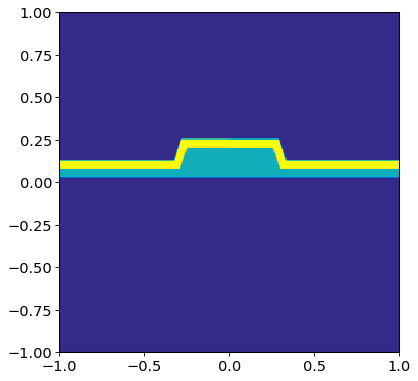

In [9]:
# prepare spatial coordinate vectors
nx = eps.shape[0]
ny = eps.shape[1]
x = Wgrid * np.linspace(-1/2., 1/2., nx)
y = Hgrid * np.linspace(-1/2., 1/2., ny)

plt.pcolormesh(x,y,eps.T)
ax = plt.gca()
ax.set_aspect('equal')
eps.shape


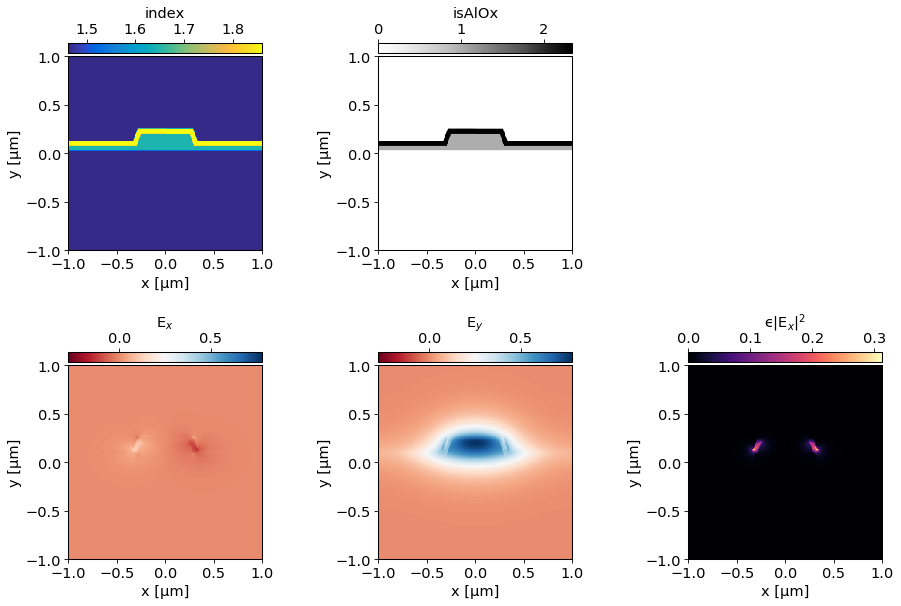

In [10]:
# plot various computed fields for this instance

fig = plt.figure(figsize=(14,10))
gs = GridSpec(2,
              3,
              wspace=0.6,
              hspace=0.2,
             )

ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax12 = fig.add_subplot(gs[1,2])


# prepare spatial coordinate vectors
nx = eps.shape[0]
ny = eps.shape[1]
x = Wgrid * np.linspace(-1/2., 1/2., nx)
y = Hgrid * np.linspace(-1/2., 1/2., ny)

# plot index as a function of space
p00 = ax00.pcolormesh(x,y,np.sqrt(eps.T),label='index')

# plot binary variable detecting core material
p01 = ax01.pcolormesh(x,y,isAlOx.T,cmap=cm.Greys,label='isAlOx')

# plot Ex, Ey and ϵ|E|^2 
vmax = e.real.max()
vmin = e.real.min()

axind = 1 
p10 = ax10.pcolormesh(x,
                      y,
                      e[:,:,0,axind].T.real,
                      cmap=cm.RdBu,
                      vmin=vmin,
                      vmax=vmax,
                     )

axind = 0 
p11 = ax11.pcolormesh(x,
                      y,
                      e[:,:,0,axind].T.real,
                      cmap=cm.RdBu,
                      vmin=vmin,
                      vmax=vmax,
                     )

axind = 1
p12 = ax12.pcolormesh(x,y,eps_ei2[:,:,axind].T,cmap=cm.magma)



## format and label plots

ax = [ax00,ax01,ax10,ax11,ax12]
p = [p00,p01,p10,p11,p12]
labels = ['index',
          'isAlOx',
          'E$_{x}$',
          'E$_{y}$',
          'ϵ|E$_x$|$^2$',
         ]




for aind,a in enumerate(ax):
    a.set_aspect('equal')
    a.set_xlabel('x [μm]')
    a.set_ylabel('y [μm]')
    divider = make_axes_locatable(a)
    cax = divider.append_axes("top", size="5%", pad=0.05)
    cb = plt.colorbar(p[aind],
                 cax=cax,
                 orientation="horizontal",
                )
    cb.set_label(labels[aind])#,labelpad=-1)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

    
# plot pAlOx_x

# divider = make_axes_locatable(ax10)
# # ax10t = divider.append_axes("bottom", size="20%", pad=0.3)
# ax10t = divider.append_axes("bottom", size=1, pad=0.1)
# # for just plotting relative shape of pAlOx_x because twinx axis is incompatible with set_aspect
# y10t = out['pAlOx_x'] #/ out['pAlOx_x'].max() * y.max() * 0.95
# ax10t.plot(x,y10t,'k--')
# ax10t.tick_params(axis='y',
#                   which='both',
#                   left=False,
#                   right=False,
#                   labelright=False,
#                   labelleft=False,
#                  )
# ax10t.set_ylim(ax10.get_ylim())
# ax10.set_aspect('equal')

dict_keys(['band', 'ng', 'pAlOx', 'pAlOx_x', 'pAlOx_strip', 'neff'])

In [11]:
e.shape

(256, 256, 1, 3)

In [63]:
#ei_pwr = eps_ei2.sum(axis=(0, 1))
ei_pwr

array([3.40997312e+02, 1.60342614e+04, 9.91153287e+00])

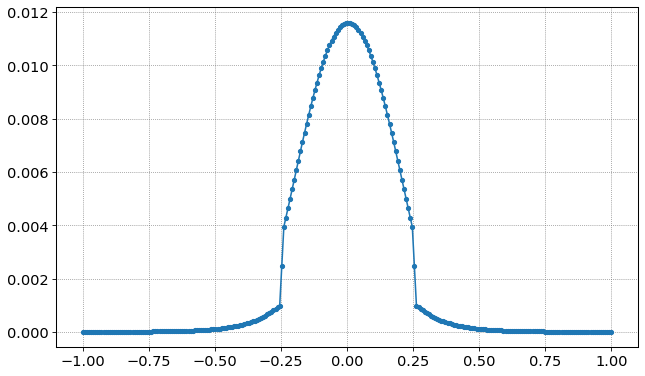

In [23]:
plt.plot(x,out['pAlOx_x'],'.-')

(256, 256)

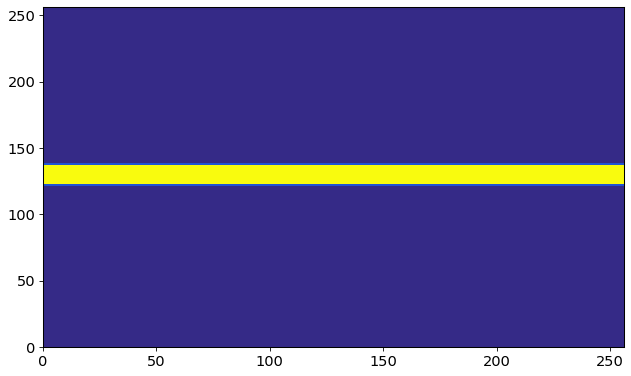

In [30]:
eps_ei2.shape

(256, 256, 3)

# Bulk dispersion